In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

print('Modules loaded')


Modules loaded


In [2]:
data_dir =  r"D:\CAPSTONE 400A\final_dataset\Tuberculosis\TB_Chest_Radiography_Database\image7500f"
filepaths = []
labels = []

for root, dirs, files in os.walk(data_dir):
    for file in files:
        file_path = os.path.join(root, file)
        filepaths.append(file_path)
        label = os.path.basename(root)
        labels.append(label)

df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
print(df)


                                              filepaths        labels
0     D:\CAPSTONE 400A\final_dataset\Tuberculosis\TB...        Normal
1     D:\CAPSTONE 400A\final_dataset\Tuberculosis\TB...        Normal
2     D:\CAPSTONE 400A\final_dataset\Tuberculosis\TB...        Normal
3     D:\CAPSTONE 400A\final_dataset\Tuberculosis\TB...        Normal
4     D:\CAPSTONE 400A\final_dataset\Tuberculosis\TB...        Normal
...                                                 ...           ...
6995  D:\CAPSTONE 400A\final_dataset\Tuberculosis\TB...  Tuberculosis
6996  D:\CAPSTONE 400A\final_dataset\Tuberculosis\TB...  Tuberculosis
6997  D:\CAPSTONE 400A\final_dataset\Tuberculosis\TB...  Tuberculosis
6998  D:\CAPSTONE 400A\final_dataset\Tuberculosis\TB...  Tuberculosis
6999  D:\CAPSTONE 400A\final_dataset\Tuberculosis\TB...  Tuberculosis

[7000 rows x 2 columns]


In [3]:
batch_size = 32
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
epochs = 10
k = 5 
NUM_CLASSES = 2


In [4]:
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()
val_gen = ImageDataGenerator()


In [5]:
kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
fold_var = 1

train_scores = []
valid_scores = []
test_scores = []
y_preds = []


In [6]:
for train_index, val_index in kf.split(df['filepaths'], df['labels']):
    print(f'Fold {fold_var}')
    
    train_df = df.iloc[train_index]
    valid_df = df.iloc[val_index]
    test_df = df.iloc[val_index]  

    train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    valid_gen = val_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=True, batch_size=batch_size)
    test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    img_size = (224, 224)
    channels = 3
    img_shape = (img_size[0], img_size[1], channels)
    class_count = len(train_gen.class_indices)
    

    base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights='imagenet', input_shape=img_shape, pooling='max')

    base_model.trainable = False  

    model = Sequential([
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(512, kernel_initializer='he_normal', activation='relu'),
    Dropout(0.2),
    Dense(256, kernel_regularizer=regularizers.l2(0.009), activity_regularizer=regularizers.l1(0.019),
          bias_regularizer=regularizers.l1(0.019), activation='relu'),
    Dropout(0.20),
    Dense(128, kernel_initializer='he_uniform', activation='relu'),
    Dropout(0.1),
    Dense(class_count, activation='softmax')
])

    model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    #model.summary()

    
    history = model.fit(x=train_gen, epochs=epochs, verbose=1, validation_data=valid_gen, validation_steps=None, shuffle=False)
    
   
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
    test_steps = ts_length // test_batch_size
    
    train_score = model.evaluate(train_gen, steps=test_steps, verbose=1)
    valid_score = model.evaluate(valid_gen, steps=test_steps, verbose=1)
    test_score = model.evaluate(test_gen, steps=test_steps, verbose=1)
    
    train_scores.append(train_score)
    valid_scores.append(valid_score)
    test_scores.append(test_score)
    
    preds = model.predict(test_gen)
    y_pred = np.argmax(preds, axis=1)
    y_preds.append(y_pred)
    
    fold_var += 1


Fold 1
Found 5600 validated image filenames belonging to 2 classes.
Found 1400 validated image filenames belonging to 2 classes.
Found 1400 validated image filenames belonging to 2 classes.
Epoch 1/10
175/175 [==============================] - 1060s 6s/step - loss: 2.0029 - accuracy: 0.9055 - val_loss: 0.6837 - val_accuracy: 0.9686
Epoch 2/10
175/175 [==============================] - 1006s 6s/step - loss: 0.4829 - accuracy: 0.9362 - val_loss: 0.3096 - val_accuracy: 0.9707
Epoch 3/10
175/175 [==============================] - 1001s 6s/step - loss: 0.3022 - accuracy: 0.9430 - val_loss: 0.2370 - val_accuracy: 0.9729
Epoch 4/10
175/175 [==============================] - 819s 5s/step - loss: 0.2590 - accuracy: 0.9457 - val_loss: 0.1969 - val_accuracy: 0.9793
Epoch 5/10
175/175 [==============================] - 633s 4s/step - loss: 0.2451 - accuracy: 0.9507 - val_loss: 0.1874 - val_accuracy: 0.9693
Epoch 6/10
175/175 [==============================] - 611s 3s/step - loss: 0.2311 - accuracy

In [7]:
train_loss = np.mean([score[0] for score in train_scores])
train_acc = np.mean([score[1] for score in train_scores])
valid_loss = np.mean([score[0] for score in valid_scores])
valid_acc = np.mean([score[1] for score in valid_scores])
test_loss = np.mean([score[0] for score in test_scores])
test_acc = np.mean([score[1] for score in test_scores])

print("Train Loss: ", train_loss)
print("Train Accuracy: ", train_acc)
print('-' * 20)
print("Validation Loss: ", valid_loss)
print("Validation Accuracy: ", valid_acc)
print('-' * 20)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_acc)


Train Loss:  0.14904344379901885
Train Accuracy:  0.9890625
--------------------
Validation Loss:  0.1680845022201538
Validation Accuracy:  0.9806250095367431
--------------------
Test Loss:  0.16496947556734085
Test Accuracy:  0.9840624928474426


In [8]:
y_true = test_gen.classes
classes = list(train_gen.class_indices.keys())
print(classification_report(y_true, y_preds[-1], target_names=classes))


              precision    recall  f1-score   support

      Normal       0.99      0.97      0.98       700
Tuberculosis       0.97      0.99      0.98       700

    accuracy                           0.98      1400
   macro avg       0.98      0.98      0.98      1400
weighted avg       0.98      0.98      0.98      1400



<Figure size 1000x1000 with 0 Axes>

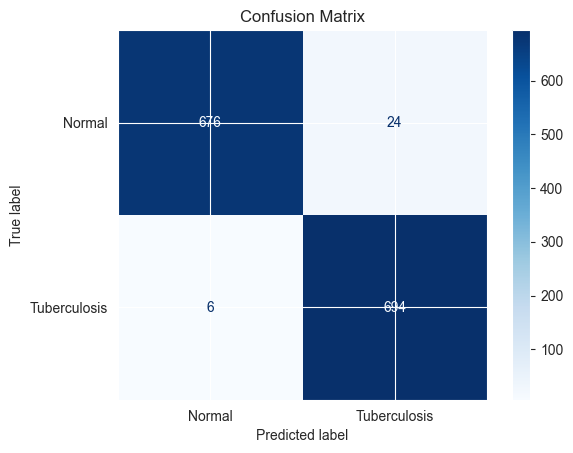

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


cm = confusion_matrix(y_true, y_preds[-1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


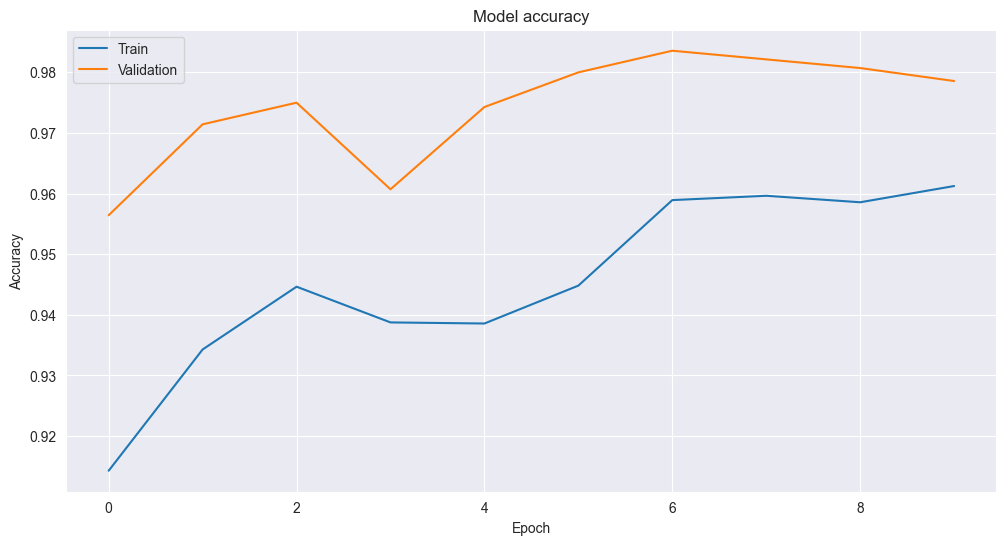

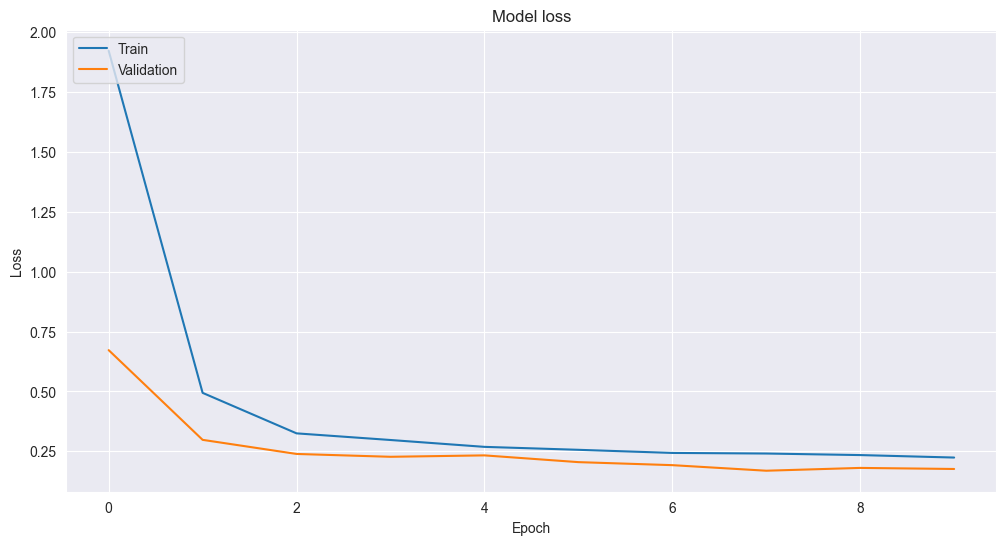

In [10]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [11]:
import tensorflow as tf
import pickle

# Save the model in HDF5 format
model.save(r"D:\CAPSTONE 400A\model\EfficientNetB3kfoldcus.h5")



In [12]:
model.save("EfficientNetB3kfoldcus.h5")